In [ ]:
!pip install -U efficientnet
import sys
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import efficientnet.keras as efn 
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [ ]:
PATH = "/content/drive/MyDrive/Melanoma_Data/Gabor_eff/"
print(os.listdir(PATH))

['train', 'valid', 'test']


In [ ]:
PATHtrain = PATH + 'train/'
print(len(os.listdir(PATHtrain)), " TRAIN Directories of photos")
Labels = os.listdir(PATHtrain)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHtrain + label +'/')))
    sig = sig + len(os.listdir(PATHtrain + label +'/'))

print("Total TRAIN photos ", sig)
print("_"*50)

PATHvalid = PATH + 'valid/'
print(len(os.listdir(PATHvalid)), " VALID Directories of photos")
Labels = os.listdir(PATHvalid)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHvalid + label +'/')))
    sig = sig + len(os.listdir(PATHvalid + label +'/'))

print("Total Validation photos ", sig)
print("_"*50)

PATHtest = PATH + 'test/'
print(len(os.listdir(PATHtest)), " TEST Directories of photos")
Labels = os.listdir(PATHtest)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHtest + label +'/')))
    sig = sig + len(os.listdir(PATHtest + label +'/'))

print("Total Testing photos ", sig)
print("_"*50)

2  TRAIN Directories of photos
Melanoma 1047
NotMelanoma 1047
Total TRAIN photos  2094
__________________________________________________
2  VALID Directories of photos
Melanoma 225
NotMelanoma 225
Total Validation photos  450
__________________________________________________
2  TEST Directories of photos
Melanoma 225
NotMelanoma 225
Total Testing photos  450
__________________________________________________


In [ ]:
from efficientnet.tfkeras import EfficientNetB4

In [ ]:
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Flatten,Dense
from keras.regularizers import l2
import tensorflow as tf

EP=30
LR=0.0001
DR=LR/EP
MM=0.8
K=0.2

"lr=0.0001"
"--USING THIS--"
def lr_scheduler(epoch, lr):return lr* float((np.exp(- (epoch*DR))))
    
LRD=LearningRateScheduler(lr_scheduler)

callbacks_list=[LRD]


#OPT=keras.optimizers.Adam(lr=lr_schedule,decy_rate=DR)

"--CORRECT WAY WITH LEARNING RATE SCHEDULE--"
OPT=tf.keras.optimizers.Adam(learning_rate=LR)


model = keras.Sequential()
model.add(EfficientNetB4(input_shape=(224, 224, 3), include_top=False, weights='imagenet'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu',kernel_regularizer=l2(0.05), bias_regularizer=l2(0.05)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(2, activation='sigmoid')) 

# monitor
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_accuracy')
model_checkpoint_callback = ModelCheckpoint(filepath='/content/drive/MyDrive/Melanoma_dataset_final/melanoma_model_gabor.hdf5',
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='auto',
                                            save_best_only=True,
                                            verbose=1)


#categorical_crossentropy
model.compile(loss='binary_crossentropy', optimizer=OPT, metrics=['accuracy', 'AUC'])

71901184/71892840 [==============================] - 1s 0us/step


In [ ]:
train_dir = PATHtrain
validation_dir = PATHvalid
test_dir = PATHtest
target_size=(224, 224)
batch_size=32
#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=target_size,batch_size=batch_size,shuffle=True,seed=42)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=target_size,batch_size=batch_size,shuffle=True,seed=42)
test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=target_size,batch_size=1)

Found 2094 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}


In [ ]:
len(test_generator.labels)


450

In [ ]:
history = model.fit(train_generator, epochs=EP, 
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.n//validation_generator.batch_size,
                    callbacks=[early_stopping_monitor,model_checkpoint_callback])

Epoch 1/30
65/65 [==============================] - 693s 10s/step - loss: 21.1311 - accuracy: 0.6159 - auc: 0.6242 - val_loss: 19.0210 - val_accuracy: 0.5625 - val_auc: 0.5931

Epoch 00001: val_accuracy improved from -inf to 0.56250, saving model to /content/drive/MyDrive/Melanoma_dataset_final/melanoma_model_gabor.hdf5
Epoch 2/30
65/65 [==============================] - 92s 1s/step - loss: 17.3456 - accuracy: 0.7008 - auc: 0.7345 - val_loss: 15.6598 - val_accuracy: 0.6161 - val_auc: 0.6544

Epoch 00002: val_accuracy improved from 0.56250 to 0.61607, saving model to /content/drive/MyDrive/Melanoma_dataset_final/melanoma_model_gabor.hdf5
Epoch 3/30
65/65 [==============================] - 92s 1s/step - loss: 14.2524 - accuracy: 0.7507 - auc: 0.7822 - val_loss: 12.9427 - val_accuracy: 0.6295 - val_auc: 0.6601

Epoch 00003: val_accuracy improved from 0.61607 to 0.62946, saving model to /content/drive/MyDrive/Melanoma_dataset_final/melanoma_model_gabor.hdf5
Epoch 4/30
65/65 [==============

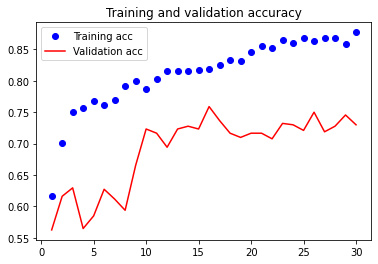

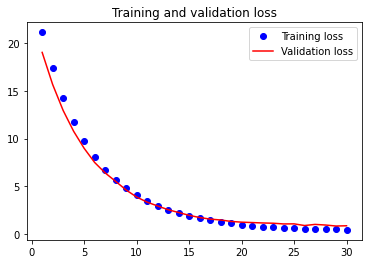

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
true_labels=np.argmax(y, axis=-1)
prediction= model.predict(test_generator, verbose=2)
prediction=np.argmax(prediction, axis=-1)

450/450 - 16s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=true_labels, y_pred=prediction)

In [ ]:
cm_plot_labels = ['melanoma','not melanoma']

Confusion matrix, without normalization
[[165  60]
 [ 44 181]]
Accuracy: 0.769
Precision: 0.751
Recall: 0.804
F-Measure: 0.777


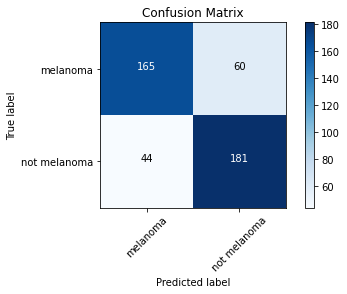

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import accuracy_score
acc=accuracy_score(true_labels,prediction) 
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction,labels=[1,2], average='micro')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='binary')
print('Recall: %.3f' % recall)
from sklearn.metrics import f1_score
score = f1_score(true_labels,prediction, average='binary')
print('F-Measure: %.3f' % score)

In [ ]:
model.save('/content/drive/MyDrive/Melanoma_Data/models/gabor_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
